In [1]:
# =========================================================
# 🔧 Import HistoDataset depuis le projet local
# =========================================================
import sys, os
from pathlib import Path

# --- Emplacement du projet quand on lance depuis notebooks/ ---
PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
DATAGENERATOR_PATH = PROJECT_ROOT / "p9dg"

# Dossiers globaux du projet
MODELS_DIR      = PROJECT_ROOT / "models"
ARTIFACTS_DIR   = PROJECT_ROOT / "artifacts"
SAMPLES_DIR     = PROJECT_ROOT / "samples"     / "02b_baseline_cnn_synth"
OUTPUTS_DIR     = PROJECT_ROOT / "outputs"     / "02b_baseline_cnn_synth"
CHECKPOINTS_DIR = PROJECT_ROOT / "checkpoints" / "02b_baseline_cnn_synth"
RUNS_DIR        = PROJECT_ROOT / "runs"        / "02b_baseline_cnn_synth"
DATA_ROOT       = Path(os.getenv("DATA_ROOT", PROJECT_ROOT / "data")).resolve()
CONFIG_DIR      = Path(os.getenv("CONFIG_DIR", PROJECT_ROOT / "configs")).resolve()

for d in [MODELS_DIR, ARTIFACTS_DIR, SAMPLES_DIR, OUTPUTS_DIR, CHECKPOINTS_DIR, RUNS_DIR, CONFIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Vérifie et ajoute au PYTHONPATH
if str(DATAGENERATOR_PATH) not in sys.path:
    sys.path.append(str(DATAGENERATOR_PATH))

# Import du dataset
from histo_dataset import HistoDataset

print(f"✅ Module histo_dataset importé depuis : {DATAGENERATOR_PATH}")
print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"DATA_ROOT: {DATA_ROOT}")
print(f"CONFIG_DIR: {CONFIG_DIR}")


✅ Module histo_dataset importé depuis : /workspace/p9dg
PROJECT_ROOT: /workspace
DATA_ROOT: /workspace/data
CONFIG_DIR: /workspace/configs


In [2]:
# Utiliser CONFIG_DIR et DATA_ROOT définis dans la cellule précédente
if "CONFIG_DIR" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    CONFIG_DIR = Path(os.getenv("CONFIG_DIR", PROJECT_ROOT / "configs")).resolve()
if "DATA_ROOT" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    DATA_ROOT = Path(os.getenv("DATA_ROOT", PROJECT_ROOT / "data")).resolve()

In [3]:
# === Cellule 1 — Construire le manual_csv à partir du split déjà présent dans le CSV ===
from pathlib import Path
import pandas as pd
import os

# Utiliser OUTPUTS_DIR défini dans la cellule précédente
if "OUTPUTS_DIR" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    OUTPUTS_DIR = PROJECT_ROOT / "outputs" / "02b_baseline_cnn_synth"

# Réglages - Les images synthétiques sont dans le dossier de génération de masse (07_diffusion_model)
# Chercher dans OUTPUTS_DIR du notebook 07 ou dans le dossier parent
if "PROJECT_ROOT" not in globals():
    PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
SYNTH_OUTPUTS_DIR = PROJECT_ROOT / "outputs" / "07_diffusion_model" / "pixcell_out_histo"
if not SYNTH_OUTPUTS_DIR.exists():
    # Fallback: chercher dans le dossier parent
    SYNTH_OUTPUTS_DIR = PROJECT_ROOT / "outputs" / "pixcell_out_histo"

DATASET_DIR = SYNTH_OUTPUTS_DIR   # dossier racine des images synthétiques

# Chercher le fichier CSV le plus récent contenant "pixcell_metadata"
if SYNTH_OUTPUTS_DIR.exists():
    metadata_files = list(SYNTH_OUTPUTS_DIR.glob("*pixcell_metadata*.csv"))
    if metadata_files:
        # Trier par date de modification (le plus récent en dernier)
        metadata_files.sort(key=lambda p: p.stat().st_mtime)
        META_CSV = metadata_files[-1]
        print(f"📌 Fichier metadata trouvé (le plus récent): {META_CSV.name}")
    else:
        raise FileNotFoundError(f"Aucun fichier CSV contenant 'pixcell_metadata' trouvé dans {SYNTH_OUTPUTS_DIR}")
else:
    raise FileNotFoundError(f"Dossier des images synthétiques introuvable: {SYNTH_OUTPUTS_DIR}")

OUT_CSV     = OUTPUTS_DIR / "synth_trainval_manual.csv"
VALID_EXTS  = {".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp", ".webp"}

# Chargement & vérifs de colonnes indispensables
df = pd.read_csv(META_CSV)
req_cols = {"out_path", "ref_label", "split"}
missing = req_cols - set(df.columns)
assert not missing, f"Colonnes manquantes dans {META_CSV.name}: {missing}"

# On ne garde que le nécessaire et on renomme pour le manual_csv attendu
df = df[["out_path", "ref_label", "split"]].rename(
    columns={"out_path": "path", "ref_label": "label"}
)

# Canonicaliser la colonne split et filtrer (on respecte strictement le CSV)
df["split"] = df["split"].astype(str).str.strip().str.lower()
df = df[df["split"].isin({"train", "val"})].copy()

# Normalisation des chemins (les images existent sous DATASET_DIR)
def resolve_out_path(p_str: str) -> str | None:
    p = Path(p_str)
    # 1) Chemin absolu direct
    if p.is_absolute() and p.exists():
        return str(p)
    # 2) Relatif à DATASET_DIR
    cand = (DATASET_DIR / p)
    if cand.exists():
        return str(cand)
    # 3) Fallback : recherche par nom de fichier si unique
    matches = list(DATASET_DIR.rglob(p.name))
    if len(matches) == 1:
        return str(matches[0])
    return None  # introuvable

df["path"] = df["path"].map(resolve_out_path)
df = df.dropna(subset=["path"])

# Filtrer extensions supportées
df = df[df["path"].map(lambda s: Path(s).suffix.lower() in VALID_EXTS)].copy()

# (Optionnel) Dédupliquer au cas où
df = df.drop_duplicates(subset=["path", "label", "split"]).reset_index(drop=True)

# Sauvegarde
OUT_CSV.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(OUT_CSV, index=False)

# Récap utile
n_total = len(df)
n_classes = df["label"].nunique()
print(f"OK → {OUT_CSV} | total={n_total} | classes={n_classes}")
print("\nTrain par classe:")
print(df[df.split=="train"]["label"].value_counts().sort_index())
print("\nVal par classe:")
print(df[df.split=="val"]["label"].value_counts().sort_index())


📌 Fichier metadata trouvé (le plus récent): pixcell_metadata_1763246785.csv
OK → /workspace/outputs/02b_baseline_cnn_synth/synth_trainval_manual.csv | total=4500 | classes=9

Train par classe:
label
ADI     400
BACK    400
DEB     400
LYM     400
MUC     400
MUS     400
NORM    400
STR     400
TUM     400
Name: count, dtype: int64

Val par classe:
label
ADI     100
BACK    100
DEB     100
LYM     100
MUC     100
MUS     100
NORM    100
STR     100
TUM     100
Name: count, dtype: int64


In [4]:
# forçage methode spawn (fix problème multiprocessing)
import torch.multiprocessing as mp
if mp.get_start_method(allow_none=True) != "spawn":
    mp.set_start_method("spawn", force=True)

In [5]:
from histo_dataset import HistoDataset
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
# Fonction de création d'un writer pour Tensorboard
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os

def create_writer(model_name, image_size, samples_per_class, vahadane_enable,
                  base_dir=None):
    """
    Crée un SummaryWriter TensorBoard avec un nom de run auto-généré,
    toujours dans /workspace/runs (indépendant du notebook courant).
    """
    # ✅ Détection absolue du dossier cible
    if base_dir is None:
        base_dir = os.getenv("TENSORBOARD_LOGDIR", "/workspace/runs")
    if not os.path.isabs(base_dir):
        base_dir = os.path.join("/workspace", base_dir)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    norm_tag = "vahadane" if vahadane_enable else "nonorm"
    run_name = f"{model_name}_{image_size}px_{samples_per_class or 'full'}pc_{norm_tag}_{timestamp}"
    
    # ✅ Construction d’un chemin absolu garanti
    log_dir = os.path.normpath(os.path.join(base_dir, run_name))
    os.makedirs(log_dir, exist_ok=True)

    writer = SummaryWriter(log_dir=log_dir)

    info_text = (
        f"**Run name:** {run_name}\n\n"
        f"**Model:** {model_name}\n"
        f"**Image size:** {image_size}px\n"
        f"**Samples per class (train):** {samples_per_class or 'full dataset'}\n"
        f"**Normalization:** {'Vahadane' if vahadane_enable else 'None'}\n"
        f"**Timestamp:** {timestamp}"
    )
    writer.add_text("RunInfo/config", info_text, 0)

    print(f"🧭 Run initialisé : {run_name}")
    print(f"📂 Logs TensorBoard -> {log_dir}")
    return writer, run_name


In [7]:
# Vidage RAM GPU
torch.cuda.empty_cache()

In [8]:
# ------------------------------
# 1️⃣ Config
# ------------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# Utiliser ARTIFACTS_DIR défini dans la cellule précédente
if "ARTIFACTS_DIR" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
IMAGE_SIZE = 128
SAMPLES_PER_CLASS = 300 # 200 (raisonnable)
SAMPLES_PER_CLASS_VAL = max(5, SAMPLES_PER_CLASS // 5)
VAHADANE_ENABLE = False

In [9]:
# ------------------------------
# 2️⃣ Dataset & DataLoader
# ------------------------------
# Utiliser CONFIG_DIR défini dans la cellule précédente
if "CONFIG_DIR" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    CONFIG_DIR = Path(os.getenv("CONFIG_DIR", PROJECT_ROOT / "configs")).resolve()

train_ds = HistoDataset(
    root_data="/", # str(DATASET_DIR),
    split="train",
    split_policy="manuel_csv", # ← on utilise le CSV des synthétiques
    manual_csv=str(OUT_CSV),
    output_size=IMAGE_SIZE, # taille initiale 244 !
    pixel_range="imagenet",
    balance_per_class=True, # ✅ essentiel pour l'échantillonage
    thresholds_json_path=str(CONFIG_DIR / "seuils_par_classe.json"),
    apply_quality_filter=False,            # synthétique → on coupe le filtre
    vahadane_enable=VAHADANE_ENABLE,       # pas de normalisation histo sur synthétique
    vahadane_device=DEVICE,
    samples_per_class_per_epoch=SAMPLES_PER_CLASS 
)

val_ds = HistoDataset(
    root_data="/", #"/workspace/data",
    split="val",
    split_policy="manual_csv",
    manual_csv=str(OUT_CSV),
    output_size=IMAGE_SIZE,
    pixel_range="imagenet",
    balance_per_class=True,
    thresholds_json_path=str(CONFIG_DIR / "seuils_par_classe.json"),
    apply_quality_filter=False,
    vahadane_enable=VAHADANE_ENABLE,
    vahadane_device=DEVICE,
    samples_per_class_per_epoch=None, # SAMPLES_PER_CLASS_VAL,
    no_repeat_eval=True
)

✅ Seuils par classe chargés depuis : /workspace/configs/seuils_par_classe.json
⚖️ Échantillonnage équilibré activé (300 images / classe).
✅ Seuils par classe chargés depuis : /workspace/configs/seuils_par_classe.json
⚖️ Échantillonnage équilibré auto (100 images / classe, min du dataset).


In [10]:
print(f"Train set size: {len(train_ds)} images")
print(f"Val set size: {len(val_ds)} images")

Train set size: 2700 images
Val set size: 900 images


In [11]:
import torch
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.set_float32_matmul_precision("high")


# Sélection du modèle : "mobilenetv2", "mobilenetv3", "mobilenetv3_large", "mobilenetv3_small" ou "resnet18"
MODEL_NAME = "mobilenetv2"  # ← par défaut
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

num_classes = len(train_ds.class_to_idx)
print(f"🧠 Nombre de classes : {num_classes}")

name = MODEL_NAME.lower()

if name == "mobilenetv2":
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
    # Dernière couche de classification
    in_features = model.classifier[1].in_features if hasattr(model.classifier[1], "in_features") else model.last_channel
    model.classifier[1] = nn.Linear(in_features, num_classes)
    arch = "MobileNetV2"

elif name in ("mobilenetv3", "mobilenetv3_large"):
    # Par défaut: V3 Large
    model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)
    arch = "MobileNetV3-Large"

elif name == "mobilenetv3_small":
    model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)
    arch = "MobileNetV3-Small"

elif name == "resnet18":
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    arch = "ResNet-18"

else:
    raise ValueError(f"Modèle non reconnu: {MODEL_NAME}")

model = model.to(DEVICE, memory_format=torch.channels_last)
print(f"✅ Modèle {arch} initialisé sur {DEVICE}")

# MobileNetV2 torchvision a souvent classifier = [Dropout(p=0.2), Linear(...)]
try:
    model.classifier[0].p = 0.4
except Exception:
    pass


🧠 Nombre de classes : 9
✅ Modèle MobileNetV2 initialisé sur cuda


In [12]:
# Préparation de l'entrainement
# Hyperparamètres
BATCH_SIZE = 8
EPOCHS = 15
LR = 5e-4 # 1e-3
PATIENCE = 6  # early stopping
NUM_WORKERS = 0
# pin_memory transfer plus rapide vers GPU

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)

val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)


criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5,
    patience=3, threshold=1e-3, cooldown=1
)

# === SWA: moyenne de poids sur la fin de l'entraînement ===
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn

USE_SWA   = True
SWA_START = max(3, int(0.6 * EPOCHS))   # commence sur le dernier tiers
swa_model = AveragedModel(model).to(DEVICE) if USE_SWA else None
swa_sched = SWALR(optimizer, swa_lr=max(LR * 0.2, 1e-5)) if USE_SWA else None


print("🧩 Dataloaders prêts.")


🧩 Dataloaders prêts.


In [13]:
# === MixUp (simple et sûr) ===
import numpy as np
USE_MIXUP, MIXUP_ALPHA = True, 0.2
MIXUP_STOP_EPOCH = max(3, int(0.6 * EPOCHS))  # ex. dernier tiers sans MixUp


def mixup_batch(x, y, alpha=MIXUP_ALPHA):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    x = lam * x + (1 - lam) * x[idx]
    return x, y, y[idx], lam

def mixup_loss(crit, pred, y_a, y_b, lam):
    return lam * crit(pred, y_a) + (1 - lam) * crit(pred, y_b)


In [14]:
# Vidage RAM GPU
torch.cuda.empty_cache()

In [15]:
# Boucle d'entrainement
# Optimisations et intégrations:
# ✅ Lissage EMA (Exponential Moving Average des poids poids)
# ✅ Early stopping robuste (warmup + min_delta + patience)
# ✅ Contrôle du surapprentissage via Δ positif
# ✅ Scheduler avec cooldown / seuil
# ✅ Gradient clipping
# ✅ Logging complet dans TensorBoard (scalars + configuration du run)
# ✅ Nettoyage GPU périodique

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from collections import deque
import numpy as np
import os

# =====================================================
# ⚙️ PARAMÈTRES D'ENTRAÎNEMENT & EARLY STOPPING
# =====================================================
WARMUP_EPOCHS = 3          # pas d'ES avant ce nombre d'époques
ES_PATIENCE   = 6          # patience pour arrêt anticipé
ES_MIN_DELTA  = 1e-3       # amélioration minimale
DELTA_POS_PATIENCE = 4     # nbre d'époques avec Δ>0 avant arrêt pour surfit
val_ema = None             # moyenne mobile de la val_loss
patience_counter = 0
delta_pos_counter = 0
# --- Initialisation améliorée ---
best_val_ema = np.inf
ES_MIN_DELTA = 1e-3  # ← amélioration minimale pour reset patience


# =====================================================
# 🧮 LISSAGE EMA
# =====================================================
def ema(prev, new, alpha=0.3):
    return new if prev is None else (alpha * new + (1 - alpha) * prev)


# =====================================================
# 🧾 INITIALISATION DU WRITER
# =====================================================
writer, RUN_NAME = create_writer(
    model_name=MODEL_NAME,
    image_size=IMAGE_SIZE,
    samples_per_class=SAMPLES_PER_CLASS,
    vahadane_enable=VAHADANE_ENABLE
)

🧭 Run initialisé : mobilenetv2_128px_300pc_nonorm_20251116_160407
📂 Logs TensorBoard -> /workspace/runs/mobilenetv2_128px_300pc_nonorm_20251116_160407


# Entrainement

In [16]:
# =====================================================
# 🚀 BOUCLE D'ENTRAÎNEMENT
# =====================================================
import numpy as np

train_losses, val_losses = [], []
scaler = torch.amp.GradScaler('cuda')



for epoch in range(EPOCHS):
    if epoch % 10 == 0:
        torch.cuda.empty_cache()
        print("🧹 Cache GPU vidé")

    train_ds.set_epoch(epoch)
    print(f"\n=== Epoch {epoch+1}/{EPOCHS} ===")

    # Geler les features pendant 2 époques pour stabiliser le début
    if epoch == 0:
        for p in model.features.parameters(): p.requires_grad = False
    if epoch == 2:
        for p in model.features.parameters(): p.requires_grad = True

    # -------------------
    # 🔹 PHASE TRAIN
    # -------------------
    model.train()
    running_loss = 0.0

    for imgs, labels, _ in tqdm(train_loader, desc="Train", leave=False):
        imgs = imgs.to(DEVICE, non_blocking=True, memory_format=torch.channels_last)
        labels = labels.to(DEVICE, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast('cuda'):
            if USE_MIXUP:
                imgs, ya, yb, lam = mixup_batch(imgs, labels)
                outputs = model(imgs)
                loss = mixup_loss(criterion, outputs, ya, yb, lam)
            else:
                outputs = model(imgs)
                loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)

    train_loss = running_loss / len(train_ds)
    train_losses.append(train_loss)

    # -------------------
    # 🔹 PHASE VALIDATION
    # -------------------
    model.eval()
    val_running_loss = 0.0
    y_true, y_pred = [], []

    with torch.inference_mode():
        for imgs, labels, _ in tqdm(val_loader, desc="Val", leave=False):
            imgs = imgs.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)
            with torch.amp.autocast('cuda'):
                outputs = model(imgs)
                loss = criterion(outputs, labels)

            val_running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    val_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    # -------------------
    # 🔹 SCHEDULER & EMA
    # -------------------
    val_ema = ema(val_ema, val_loss, alpha=0.3)
    if USE_SWA and epoch >= SWA_START:
        swa_model.update_parameters(model)
        swa_sched.step()             # on bascule sur l'horaire SWA
    else:
        scheduler.step(val_loss)     # ReduceLROnPlateau sur la vraie val_loss

    # -------------------
    # 🔹 LOGS TENSORBOARD
    # -------------------
    current_lr = optimizer.param_groups[0]['lr']
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("Loss/val_ema", val_ema, epoch)
    writer.add_scalar("LearningRate", current_lr, epoch)
    writer.add_scalars("Loss/grouped", {"train": train_loss, "val": val_loss}, epoch)
    writer.flush()

    # -------------------
    # 🔹 AFFICHAGE ÉPOQUE
    # -------------------
    delta_raw = val_loss - train_loss
    delta_ema = val_ema - train_loss
    print(f"LR: {current_lr:.2e}")
    print(f"📊 Epoch {epoch+1:02d}/{EPOCHS} | "
          f"Train: {train_loss:.4f} | Val: {val_loss:.4f} | "
          f"Val(EMA): {val_ema:.4f} | Δraw={delta_raw:+.4f} | Δema={delta_ema:+.4f}")

    # -------------------
    # ⚠️ SURAPPRENTISSAGE
    # -------------------
    if epoch + 1 <= WARMUP_EPOCHS:
        delta_pos_counter = 0  # ← pas de comptage pendant warmup
    else:
        if delta_ema > 0:
            delta_pos_counter += 1
            if delta_pos_counter >= DELTA_POS_PATIENCE:
                print(f"⚠️ Δema > 0 sur {DELTA_POS_PATIENCE} époques consécutives → arrêt pour surapprentissage.")
                break
        else:
            delta_pos_counter = 0

    # -------------------
    # 🛑 EARLY STOPPING
    # -------------------
    if epoch + 1 <= WARMUP_EPOCHS:
        improved = False  # ← on ignore les early stops au début
    else:
        improved = (best_val_ema - val_ema) > ES_MIN_DELTA

    # -------------------
    # 🛑 EARLY STOPPING
    # -------------------
    # Utiliser MODELS_DIR défini dans la cellule précédente
    if "MODELS_DIR" not in globals():
        if "PROJECT_ROOT" not in globals():
            PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
        MODELS_DIR = PROJECT_ROOT / "models"
    MODELS_DIR.mkdir(parents=True, exist_ok=True)
    
    if improved:
        best_val_ema = val_ema
        patience_counter = 0
        best_model_path = MODELS_DIR / f"{MODEL_NAME}_best.pt"
        torch.save(model.state_dict(), best_model_path)
    else:
        patience_counter += 1
        if patience_counter >= ES_PATIENCE:
            print("⏸️ Early stopping déclenché (EMA).")
            break

    # Si SWA activé: mettre à jour les stats BN et évaluer le modèle SWA
    if USE_SWA:
        print("🔁 SWA: update batch-norm…")
        model.eval()
        update_bn(train_loader, swa_model, device=DEVICE)
        model_for_eval = swa_model
    else:
        model_for_eval = model

# =====================================================
# 🧪 Évaluation finale sur le meilleur modèle
# =====================================================
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import io, time
from PIL import Image
import torch
import numpy as np

# --- Chrono global (si tu veux mesurer le temps d'entraînement complet) ---
elapsed = (time.time() - start_time) / 60 if 'start_time' in locals() else None
if elapsed:
    print(f"⏱️ Durée totale d'entraînement : {elapsed:.2f} minutes")

# --- Rechargement du meilleur modèle ---
# Utiliser MODELS_DIR défini dans la cellule précédente
if "MODELS_DIR" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    MODELS_DIR = PROJECT_ROOT / "models"
best_model_path = MODELS_DIR / f"{MODEL_NAME}_best.pt"
if best_model_path.exists():
    model.load_state_dict(torch.load(best_model_path, map_location=DEVICE, weights_only=True))
    print(f"🏅 Meilleur modèle rechargé depuis : {best_model_path}")
else:
    print("⚠️ Aucun modèle sauvegardé, utilisation du modèle actuel.")

# --- Passage en mode évaluation ---
model_for_eval.eval()
y_true, y_pred = [], []
with torch.inference_mode():
    for imgs, labels, _ in tqdm(val_loader, desc="Final evaluation"):
        imgs   = imgs.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)
        outputs = model_for_eval(imgs)
        preds = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


# =====================================================
# 📊 Fonctions utilitaires
# =====================================================
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel("Prédictions")
    ax.set_ylabel("Vérités terrain")
    ax.set_title("Matrice de confusion (meilleur modèle)")
    fig.tight_layout()
    return fig

def fig_to_tensor(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    image = Image.open(buf)
    image = np.array(image)
    image = torch.tensor(image).permute(2,0,1)[:3]  # HWC→CHW
    buf.close()
    plt.close(fig)
    return image.unsqueeze(0)  # (1,3,H,W)



# =====================================================
# 📈 Envoi des figures finales dans TensorBoard
# =====================================================
class_names = list(train_ds.class_to_idx.keys())

# --- Matrice de confusion ---
fig_cm = plot_confusion_matrix(y_true, y_pred, class_names)
writer.add_images("Final/ConfusionMatrix", fig_to_tensor(fig_cm), 0)

# --- Rapport de classification (métriques + résumé global) ---
report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    output_dict=True,
    zero_division=0
)

for cls, metrics in report.items():
    if isinstance(metrics, dict):  # éviter la clé 'accuracy'
        for k, v in metrics.items():
            writer.add_scalar(f"Final/{cls}/{k}", v, 0)

# --- Accuracy globale ---
global_acc = report.get("accuracy", 0.0)
writer.add_scalar("Final/Global/accuracy", global_acc, 0)
print(f"🎯 Accuracy globale : {global_acc:.4f}")

# --- Rapport textuel lisible ---
report_text = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    zero_division=0
)
writer.add_text("Final/ClassificationReport", f"```\n{report_text}\n```", 0)

# --- Rapport sous forme d’image ---
fig_report, ax = plt.subplots(figsize=(7,3))
ax.axis("off")
ax.text(0, 1, report_text, fontsize=10, family="monospace", va="top")
ax.set_title("=== Rapport de classification ===", fontweight="bold", loc="center")
fig_report.tight_layout()
writer.add_images("Final/ClassificationReportImage", fig_to_tensor(fig_report), 0)

# =====================================================
# 📉 Courbe de perte (train / val)
# =====================================================
fig_loss, ax = plt.subplots(figsize=(6,4))
ax.plot(train_losses, label='Train', marker='o')
ax.plot(val_losses, label='Validation', marker='s')
ax.set_title(f"Courbe de perte ({MODEL_NAME})")
ax.set_xlabel("Époques")
ax.set_ylabel("Loss")
ax.legend()
ax.grid(True)
fig_loss.tight_layout()
writer.add_images("Final/LossCurve", fig_to_tensor(fig_loss), 0)

# =====================================================
# 🕒 Temps total d'entraînement 
# =====================================================
if elapsed:
    writer.add_scalar("Final/Global/TrainingDuration_min", elapsed, 0)

# =====================================================
# ✅ Clôture propre
# =====================================================
writer.flush()
writer.close()

print("\n📈 Matrice de confusion, rapport de classification, accuracy globale et courbe de loss loggés dans TensorBoard.")
if "RUNS_DIR" in globals():
    print(f"📊 Résultats disponibles dans : {RUNS_DIR / RUN_NAME}")
else:
    print(f"📊 Résultats disponibles dans : {RUN_NAME}")
print("🔗 Lien TensorBoard : http://localhost:6006")

🧹 Cache GPU vidé
⚖️ Échantillonnage équilibré activé (300 images / classe).

=== Epoch 1/15 ===


LR: 5.00e-04
📊 Epoch 01/15 | Train: 1.5670 | Val: 1.1042 | Val(EMA): 1.1042 | Δraw=-0.4628 | Δema=-0.4628
🔁 SWA: update batch-norm…
⚖️ Échantillonnage équilibré activé (300 images / classe).

=== Epoch 2/15 ===


LR: 5.00e-04
📊 Epoch 02/15 | Train: 1.2923 | Val: 1.0572 | Val(EMA): 1.0901 | Δraw=-0.2351 | Δema=-0.2022
🔁 SWA: update batch-norm…
⚖️ Échantillonnage équilibré activé (300 images / classe).

=== Epoch 3/15 ===


KeyboardInterrupt: 

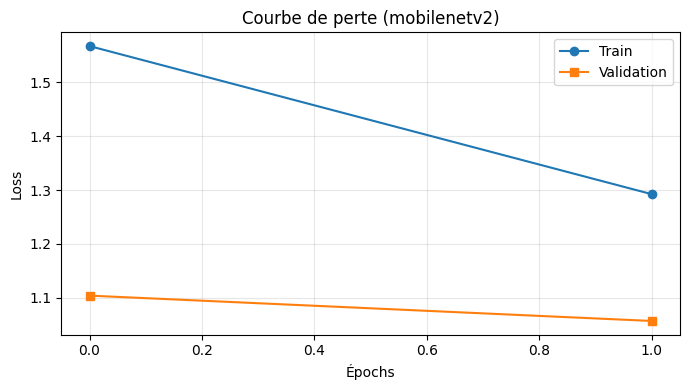

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(train_losses, label="Train", marker="o")
plt.plot(val_losses, label="Validation", marker="s")
plt.title(f"Courbe de perte ({MODEL_NAME})")
plt.xlabel("Épochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [18]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Chargement du meilleur modèle
# Utiliser MODELS_DIR défini dans la cellule précédente
if "MODELS_DIR" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    MODELS_DIR = PROJECT_ROOT / "models"
best_path = MODELS_DIR / f"{MODEL_NAME}_best.pt"
state_dict = torch.load(best_path, map_location=DEVICE, weights_only=True)
model.load_state_dict(state_dict)
model.eval()
print(f"✅ Meilleur modèle chargé depuis : {best_path}")


✅ Meilleur modèle chargé depuis : /workspace/models/mobilenetv2_best.pt


In [19]:
# 2️⃣ Prédiction sur le jeu de validation
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels, _ in tqdm(val_loader, desc="Évaluation finale"):
        imgs = imgs.to(DEVICE)
        with torch.amp.autocast('cuda'):
            outputs = model(imgs)
        preds = outputs.argmax(dim=1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())


Évaluation finale: 100%|██████████| 113/113 [00:17<00:00,  6.58it/s]


In [20]:
# 3️⃣ Rapport de classification (macro-F1, recall, précision)
classes = list(train_ds.class_to_idx.keys())

print("\n=== Rapport de classification ===")
print(classification_report(
    y_true, y_pred,
    target_names=classes,
    digits=3,
    zero_division=0
))



=== Rapport de classification ===
              precision    recall  f1-score   support

         ADI      0.702     0.400     0.510       100
        BACK      0.027     0.090     0.041       100
         DEB      0.000     0.000     0.000       100
         LYM      0.833     0.150     0.254       100
         MUC      0.000     0.000     0.000       100
         MUS      1.000     0.020     0.039       100
        NORM      0.394     0.610     0.478       100
         STR      0.000     0.000     0.000       100
         TUM      0.049     0.160     0.075       100

    accuracy                          0.159       900
   macro avg      0.334     0.159     0.155       900
weighted avg      0.334     0.159     0.155       900



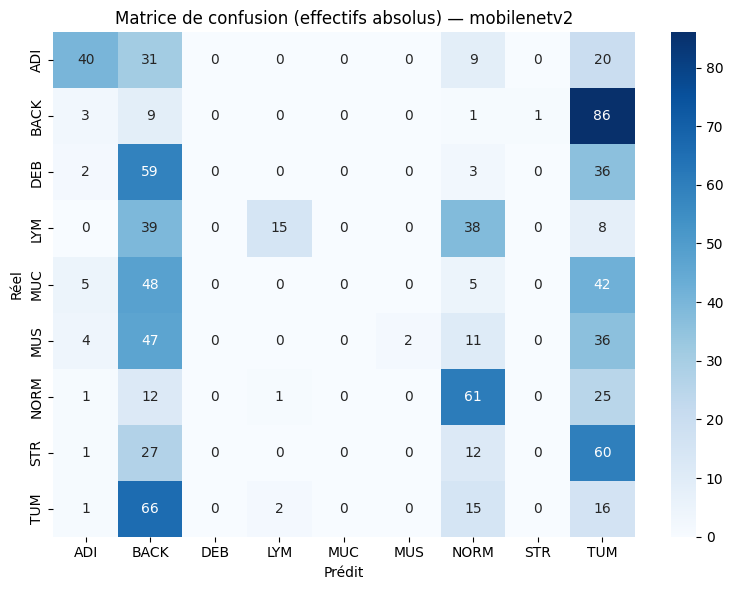

In [21]:
# 4️⃣ Matrice de confusion normalisée

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Matrice de confusion (valeurs absolues)
cm = confusion_matrix(y_true, y_pred)  # 👈 pas de normalize ici

plt.figure(figsize=(8,6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=classes, yticklabels=classes
)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title(f"Matrice de confusion (effectifs absolus) — {MODEL_NAME}")
plt.tight_layout()
plt.show()



## Test OOD (sur des images différentes et  non normalisées)

In [22]:
# === Cellule 1 : manifeste OOD échantillonné ===
from pathlib import Path
import csv, random

# Utiliser DATA_ROOT et ARTIFACTS_DIR définis dans la cellule précédente
if "DATA_ROOT" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    DATA_ROOT = Path(os.getenv("DATA_ROOT", PROJECT_ROOT / "data")).resolve()
if "ARTIFACTS_DIR" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"

NONORM_DIR = DATA_ROOT / "NCT-CRC-HE-100K-NONORM"  # racine OOD
MANIFEST_OOD_CSV = ARTIFACTS_DIR / "manifest_ood_nonorm.csv"
MANIFEST_OOD_CSV.parent.mkdir(parents=True, exist_ok=True)

# Paramètres d'échantillonnage
SEED = 123
MAX_PER_CLASS_OOD = 200  # ajuste à ta convenance

random.seed(SEED)

# On suppose la même arborescence que NCT : <NONORM_DIR>/<CLASS>/*.png|*.tif|...
exts = {".png", ".jpg", ".jpeg", ".tif", ".tiff"}
rows = []
classes = sorted([d.name for d in NONORM_DIR.iterdir() if d.is_dir()])

for c in classes:
    files = [str(p) for p in (NONORM_DIR / c).iterdir() if p.suffix.lower() in exts]
    if not files:
        continue
    random.shuffle(files)
    take = files[:MAX_PER_CLASS_OOD]
    for fp in take:
        rows.append({"path": fp, "label": c, "split": "test"})  # on marque tout en test (OOD)

with MANIFEST_OOD_CSV.open("w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["path", "label", "split"])
    writer.writeheader()
    writer.writerows(rows)

print(f"✅ Manifeste OOD créé : {MANIFEST_OOD_CSV} ({len(rows)} images, {len(classes)} classes)")


✅ Manifeste OOD créé : /workspace/artifacts/manifest_ood_nonorm.csv (1800 images, 9 classes)


In [23]:
# === Cellule 2 : dataset + loader OOD ===
import torch
from torch.utils.data import DataLoader
from histo_dataset import HistoDataset
from utils.class_mappings import make_idx_mappings

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# IMPORTANT :
# - split_policy='manual_csv' pour pointer vers notre manifeste
# - split='test' car c'est un test OOD
# - no_repeat_eval=True pour figer la sélection (reproductible)
# - samples_per_class_per_epoch pour contrôler l'échantillon OOD
# - vahadane_enable=False pour VRAIMENT tester le décalage "non-normalisé"
SAMPLES_PER_CLASS_PER_EPOCH = 100  # <= peut être différent de MAX_PER_CLASS_OOD

# Utiliser CONFIG_DIR défini dans la cellule précédente
if "CONFIG_DIR" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    CONFIG_DIR = Path(os.getenv("CONFIG_DIR", PROJECT_ROOT / "configs")).resolve()

ds_ood = HistoDataset(
    root_data="/",                         # ignoré en mode manual_csv
    split="test",
    split_policy="manual_csv",
    manual_csv=str(MANIFEST_OOD_CSV),
    output_size=IMAGE_SIZE,                       # doit matcher le training
    pixel_range="imagenet",                # idem que le training si tu utilisais ImageNet
    balance_per_class=True,
    samples_per_class_per_epoch=SAMPLES_PER_CLASS_PER_EPOCH,
    no_repeat_eval=True,
    vahadane_enable=False,                 # clé pour OOD "NONORM"
    vahadane_device="cpu",
    thresholds_json_path="seuils_par_classe.json",  # OK (n’impacte pas test)
)

# Mappings lisibles
idx_to_name, idx_to_color, name_to_color = make_idx_mappings(ds_ood.class_to_idx)

loader_ood = DataLoader(
    ds_ood,
    batch_size=64,
    shuffle=False,   # le dataset gèle déjà l’échantillon via no_repeat_eval
    num_workers=0,   # ajuste si besoin
    pin_memory=True if DEVICE == "cuda" else False
)

print("Classes OOD :", {i: n for i, n in idx_to_name.items()})
print("Taille OOD  :", len(ds_ood))


✅ Seuils par classe chargés depuis : /workspace/configs/seuils_par_classe.json
⚖️ Échantillonnage équilibré activé (100 images / classe).
Classes OOD : {0: 'Tissu adipeux', 1: 'Arrière-plan (fond sans tissu)', 2: 'Débris cellulaires / nécrose', 3: 'Lymphocytes (infiltrat immunitaire)', 4: 'Mucus (sécrétions)', 5: 'Tissu musculaire lisse', 6: 'Muqueuse colique normale', 7: 'Stroma associé au cancer', 8: 'Épithélium adénocarcinomateux (tumeur)'}
Taille OOD  : 900


Chargement du modèle depuis : /workspace/models/mobilenetv2_best.pt
✅ Modèle chargé et prêt pour l'inférence OOD.


Évaluation OOD: 100%|██████████| 15/15 [00:12<00:00,  1.19batch/s]



🎯 Accuracy globale OOD : 0.1267

=== Rapport de classification (OOD) ===
              precision    recall  f1-score   support

         ADI      0.607     0.170     0.266       100
        BACK      0.007     0.020     0.011       100
         DEB      0.000     0.000     0.000       100
         LYM      0.000     0.000     0.000       100
         MUC      0.000     0.000     0.000       100
         MUS      0.000     0.000     0.000       100
        NORM      0.355     0.590     0.444       100
         STR      0.000     0.000     0.000       100
         TUM      0.084     0.360     0.137       100

    accuracy                          0.127       900
   macro avg      0.117     0.127     0.095       900
weighted avg      0.117     0.127     0.095       900

📄 Rapport OOD exporté : /workspace/artifacts/ood_report.csv
📄 CM absolue : /workspace/artifacts/ood_confusion_abs.csv
📄 CM normalisée : /workspace/artifacts/ood_confusion_norm.csv


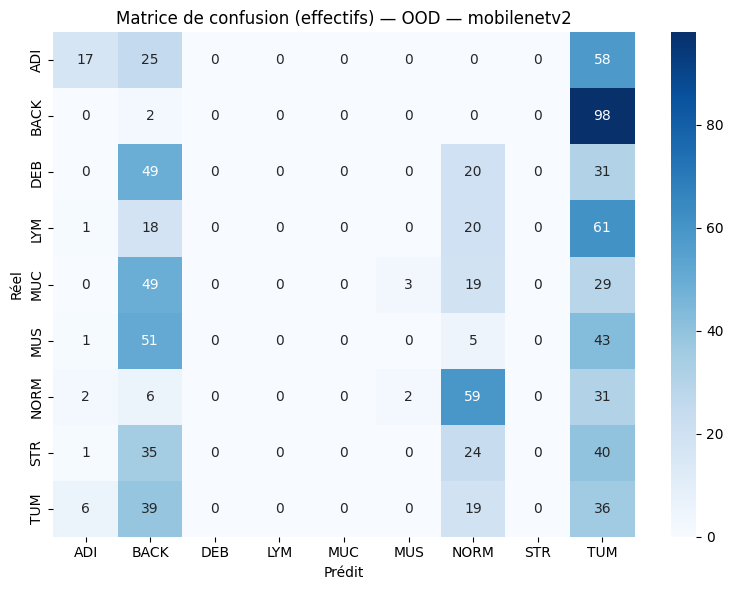

🖼️ CM (absolue) sauvegardée : /workspace/artifacts/figs/ood_cm_abs_mobilenetv2.png


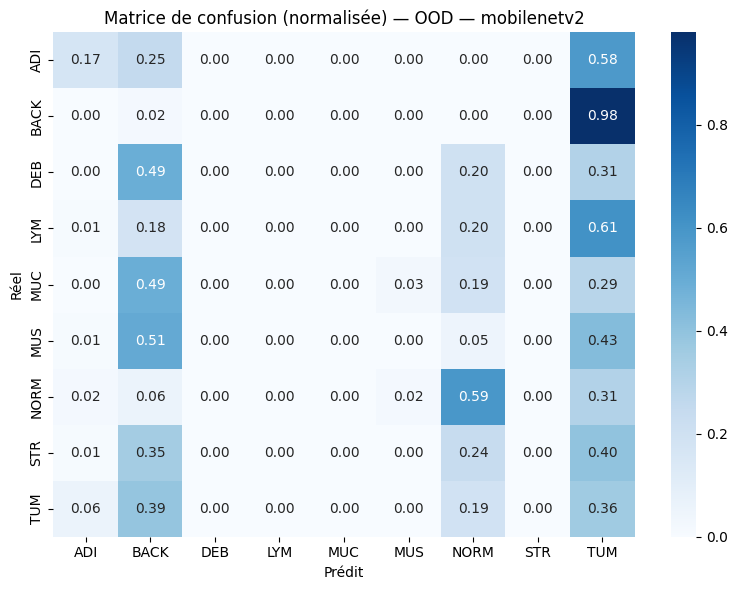

🖼️ CM (normalisée) sauvegardée : /workspace/artifacts/figs/ood_cm_norm_mobilenetv2.png

✅ Inférence OOD terminée.
- Accuracy OOD          : 0.1267
- Export métriques CSV  : ood_report.csv, ood_confusion_abs.csv, ood_confusion_norm.csv
- Figures PNG           : ood_cm_abs_mobilenetv2.png, ood_cm_norm_mobilenetv2.png


In [24]:
# === Cellule 3 : Inférence OOD complète (métriques + exports) ===
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from contextlib import nullcontext
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- Config/export ----------
# Utiliser ARTIFACTS_DIR et MODELS_DIR définis dans la cellule précédente
if "ARTIFACTS_DIR" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
if "MODELS_DIR" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    MODELS_DIR = PROJECT_ROOT / "models"
ART_DIR = ARTIFACTS_DIR
ART_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = ART_DIR / "figs"
FIG_DIR.mkdir(parents=True, exist_ok=True)

BEST_PATH = MODELS_DIR / f"{MODEL_NAME}_best.pt"   # doit exister (cf. ton entraînement)
REPORT_CSV = ART_DIR / "ood_report.csv"
CM_ABS_CSV = ART_DIR / "ood_confusion_abs.csv"
CM_NORM_CSV = ART_DIR / "ood_confusion_norm.csv"
CM_ABS_PNG = FIG_DIR / f"ood_cm_abs_{MODEL_NAME}.png"
CM_NORM_PNG = FIG_DIR / f"ood_cm_norm_{MODEL_NAME}.png"

# ---------- Chargement du meilleur modèle ----------
print(f"Chargement du modèle depuis : {BEST_PATH}")
state_dict = None
try:
    # torch>=2.0
    state_dict = torch.load(BEST_PATH, map_location=DEVICE, weights_only=True)
except TypeError:
    # Compat torch<2.0
    state_dict = torch.load(BEST_PATH, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval().to(DEVICE)
print("✅ Modèle chargé et prêt pour l'inférence OOD.")

# ---------- Contexte AMP selon device ----------
amp_ctx = torch.amp.autocast(device_type="cuda") if DEVICE.startswith("cuda") else nullcontext()

# ---------- Inférence ----------
y_true, y_pred = [], []
with torch.no_grad(), amp_ctx:
    for imgs, labels, _paths in tqdm(loader_ood, desc="Évaluation OOD", unit="batch"):
        imgs = imgs.to(DEVICE, non_blocking=True)
        logits = model(imgs)
        preds = logits.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        # labels peuvent déjà être sur CPU selon ton DataLoader
        y_true.extend(labels.cpu().numpy() if hasattr(labels, "cpu") else labels.numpy())

y_true = np.asarray(y_true)
y_pred = np.asarray(y_pred)

# ---------- Noms de classes depuis le Dataset OOD (ordre par index) ----------
num_classes = len(ds_ood.class_to_idx)
idx_to_name = {v: k for k, v in ds_ood.class_to_idx.items()}
classes = [idx_to_name[i] for i in range(num_classes)]

# ---------- Métriques globales ----------
acc = accuracy_score(y_true, y_pred)
print(f"\n🎯 Accuracy globale OOD : {acc:.4f}")

print("\n=== Rapport de classification (OOD) ===")
rep_txt = classification_report(
    y_true, y_pred,
    target_names=classes,
    digits=3,
    zero_division=0
)
print(rep_txt)

# Version DataFrame (pour export)
rep_dict = classification_report(
    y_true, y_pred,
    target_names=classes,
    digits=3,
    zero_division=0,
    output_dict=True
)

rep_df = pd.DataFrame(rep_dict).T  # 👈 au lieu de DataFrame.from_dict(..., orient="index")
rep_df["accuracy_global"] = acc    # optionnel : rajouter ta métrique d’accuracy globale
rep_df.to_csv(REPORT_CSV)

print(f"📄 Rapport OOD exporté : {REPORT_CSV}")

# ---------- Matrices de confusion ----------
cm_abs = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))  # absolu
cm_norm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)), normalize="true")  # normalisée par ligne

pd.DataFrame(cm_abs, index=classes, columns=classes).to_csv(CM_ABS_CSV)
pd.DataFrame(cm_norm, index=classes, columns=classes).to_csv(CM_NORM_CSV)
print(f"📄 CM absolue : {CM_ABS_CSV}")
print(f"📄 CM normalisée : {CM_NORM_CSV}")

# ---------- Visualisations ----------
plt.figure(figsize=(8, 6))
sns.heatmap(cm_abs, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Prédit"); plt.ylabel("Réel")
plt.title(f"Matrice de confusion (effectifs) — OOD — {MODEL_NAME}")
plt.tight_layout()
plt.savefig(CM_ABS_PNG, dpi=150)
plt.show()
print(f"🖼️ CM (absolue) sauvegardée : {CM_ABS_PNG}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Prédit"); plt.ylabel("Réel")
plt.title(f"Matrice de confusion (normalisée) — OOD — {MODEL_NAME}")
plt.tight_layout()
plt.savefig(CM_NORM_PNG, dpi=150)
plt.show()
print(f"🖼️ CM (normalisée) sauvegardée : {CM_NORM_PNG}")

# ---------- Récapitulatif ----------
print("\n✅ Inférence OOD terminée.")
print(f"- Accuracy OOD          : {acc:.4f}")
print(f"- Export métriques CSV  : {REPORT_CSV.name}, {CM_ABS_CSV.name}, {CM_NORM_CSV.name}")
print(f"- Figures PNG           : {CM_ABS_PNG.name}, {CM_NORM_PNG.name}")


Résumé — FN: 64 (uniques: 54) | FP: 391 (uniques: 304)


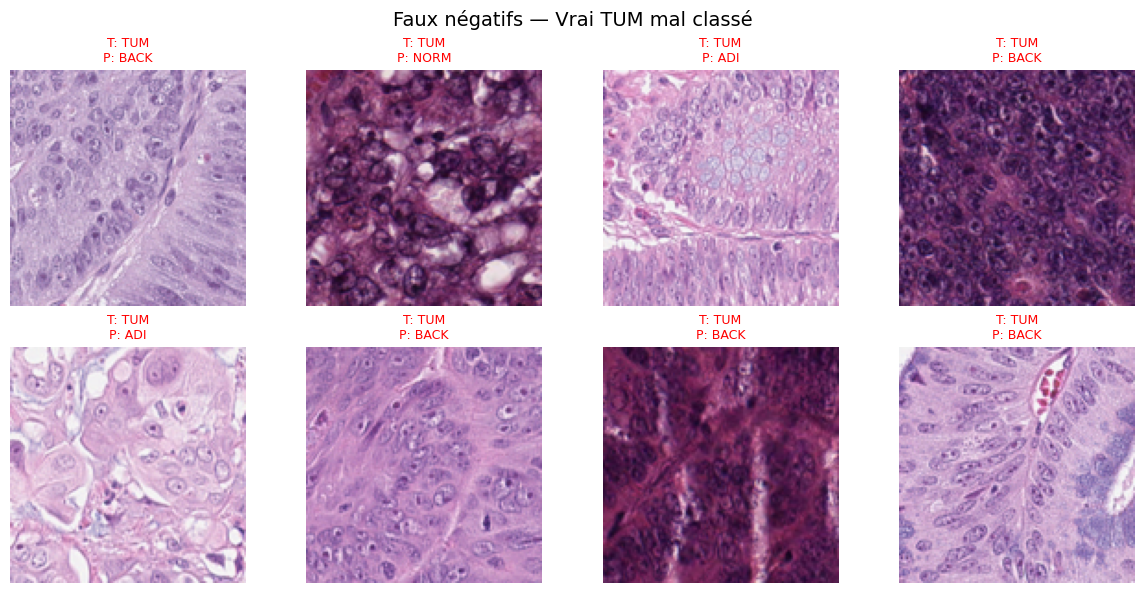

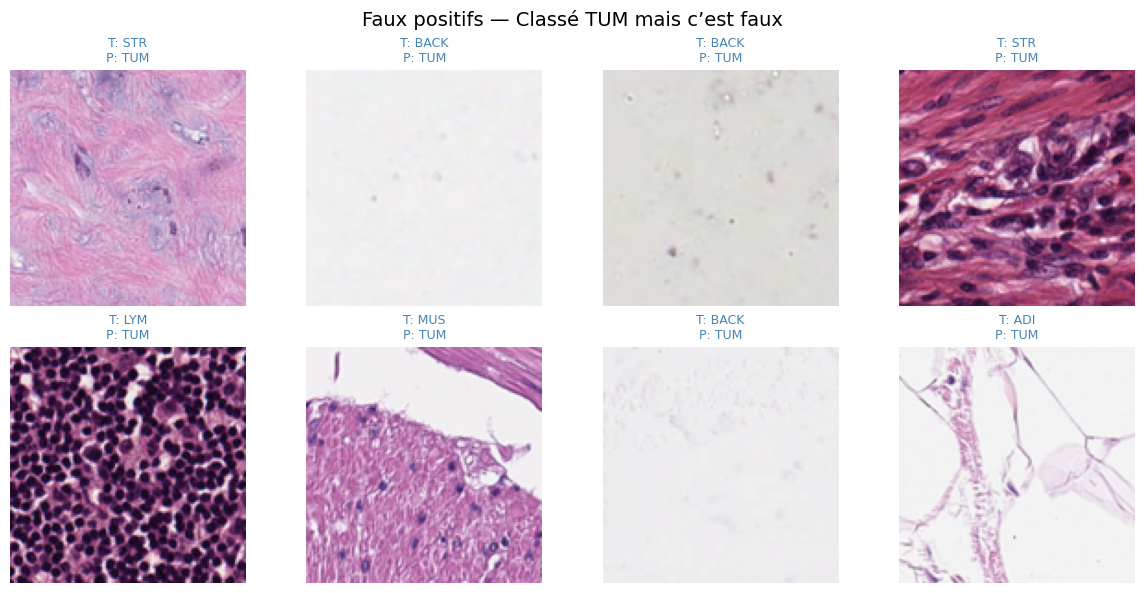

In [27]:
# 🔎 Déduplication par chemin de fichier (préserve l’ordre d’apparition)
def unique_by_path(indices, ds):
    seen, uniq = set(), []
    for i in indices:
        ci, j = ds._epoch_indices[i]
        p = ds_ood.paths_by_class[ci][j]
        if p not in seen:
            seen.add(p); uniq.append(i)
    return uniq

# ✅ Recalcul des erreurs (inchangé)
tum_idx = [k for k, v in idx_to_name.items() if v == "TUM"][0]
fn_idxs = [i for i, (yt, yp) in enumerate(zip(y_true, y_pred)) if yt == tum_idx and yp != tum_idx]
fp_idxs = [i for i, (yt, yp) in enumerate(zip(y_true, y_pred)) if yt != tum_idx and yp == tum_idx]

# ✂️ Dédup pour les figures
fn_idxs_u = unique_by_path(fn_idxs, ds_ood)
fp_idxs_u = unique_by_path(fp_idxs, ds_ood)

print(f"Résumé — FN: {len(fn_idxs)} (uniques: {len(fn_idxs_u)}) | "
      f"FP: {len(fp_idxs)} (uniques: {len(fp_idxs_u)})")

# ✅ Affichage robuste (gère n=0)
def show_images_grid(indices, title, color, ncols=4, image_size=(128, 128), fontsize=9, max_images=8):
    import matplotlib.pyplot as plt

    n = min(len(indices), max_images)

    if n == 0:
        fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
        fig.suptitle(title, fontsize=14)
        ax.text(0.5, 0.55, "Aucun exemple à afficher", ha="center", va="center", fontsize=12)
        ax.text(0.5, 0.25, "\u2713 aucune erreur détectée pour ce cas",  # ✓
                ha="center", va="center", fontsize=10, color=color)
        ax.axis("off")
        plt.tight_layout()
        plt.subplots_adjust(top=0.78)
        plt.show()
        return

    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3))
    axes = axes.flatten() if hasattr(axes, "flatten") else [axes]
    fig.suptitle(title, fontsize=14)

    for ax_idx, ax in enumerate(axes):
        if ax_idx < n:
            idx = indices[ax_idx]
            try:
                ci, j = ds_ood._epoch_indices[idx]
                img, _ = ds_ood._load_path(ci, j)  # charge PIL.Image
                img = img.resize(image_size)
                true_label = idx_to_name[y_true[idx]]
                pred_label = idx_to_name[y_pred[idx]]
                ax.imshow(img)
                ax.set_title(f"T: {true_label}\nP: {pred_label}", color=color, fontsize=fontsize)
            except Exception as e:
                ax.text(0.5, 0.5, f"Erreur chargement\nidx={idx}\n{e}", ha="center", va="center", fontsize=8)
        ax.axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

# 🖼️ Affichage (sur les listes dédupliquées)
show_images_grid(fn_idxs_u, "Faux négatifs — Vrai TUM mal classé", color="red", ncols=4)
show_images_grid(fp_idxs_u, "Faux positifs — Classé TUM mais c’est faux", color="steelblue", ncols=4)


⚖️ Balanced accuracy OOD : 0.1267


Entropy pass: 100%|██████████| 15/15 [00:12<00:00,  1.24batch/s]


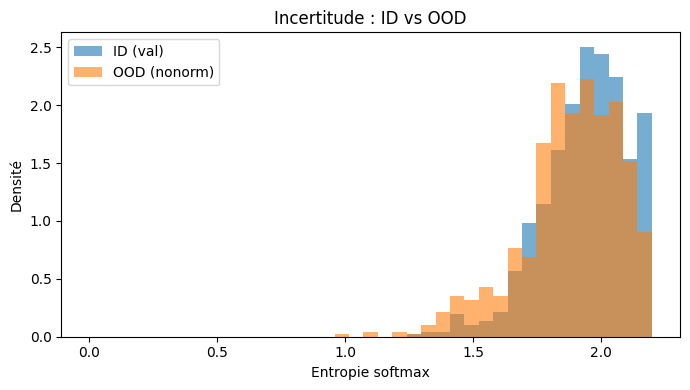

📄 Entropies sauvées dans /workspace/artifacts/uncertainty_*.csv ; figure dans /workspace/artifacts/figs/


In [28]:
# === Balanced accuracy (OOD) ===
from sklearn.metrics import balanced_accuracy_score
bal_acc = balanced_accuracy_score(y_true, y_pred)
print(f"⚖️ Balanced accuracy OOD : {bal_acc:.4f}")

# === Entropie softmax : ID (val) vs OOD ===
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

def collect_entropy(loader):
    ent = []
    model.eval()
    with torch.no_grad():
        for imgs, _, _ in tqdm(loader, desc="Entropy pass", unit="batch"):
            logits = model(imgs.to(DEVICE))
            p = F.softmax(logits, dim=1).cpu().numpy()
            # entropie de Shannon, base e
            e = -(p * (np.log(p + 1e-12))).sum(axis=1)
            ent.extend(e.tolist())
    return np.array(ent)

ent_id  = collect_entropy(val_loader)      # ID = validation in-distribution
ent_ood = collect_entropy(loader_ood)      # OOD = NONORM

# Quick viz
plt.figure(figsize=(7,4))
bins = np.linspace(0, np.log(len(classes))+1e-6, 40)  # borne max ~ log(K)
plt.hist(ent_id, bins=bins, alpha=0.6, label="ID (val)", density=True)
plt.hist(ent_ood, bins=bins, alpha=0.6, label="OOD (nonorm)", density=True)
plt.xlabel("Entropie softmax"); plt.ylabel("Densité"); plt.legend()
plt.title("Incertitude : ID vs OOD")
plt.tight_layout()
# Utiliser ARTIFACTS_DIR défini dans la cellule précédente
if "ARTIFACTS_DIR" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
FIG_DIR = ARTIFACTS_DIR / "figs"
FIG_DIR.mkdir(parents=True, exist_ok=True)
plt.savefig(str(FIG_DIR / "uncertainty_id_vs_ood.png"), dpi=150)
plt.show()

# Sauvegarde CSV pour analyse ultérieure
import pandas as pd
pd.DataFrame({"entropy": ent_id,  "set": "ID"}).to_csv(str(ARTIFACTS_DIR / "uncertainty_id.csv"),  index=False)
pd.DataFrame({"entropy": ent_ood, "set": "OOD"}).to_csv(str(ARTIFACTS_DIR / "uncertainty_ood.csv"), index=False)
print(f"📄 Entropies sauvées dans {ARTIFACTS_DIR}/uncertainty_*.csv ; figure dans {FIG_DIR}/")
